In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import time
from tqdm import tqdm
from torch import Tensor,deg2rad,sin,asin,cos,sqrt,min,max#
from torch.utils.data import DataLoader
pd.set_option('display.max_columns', None)

In [3]:
#auto=pd.read_csv('/content/drive/MyDrive/rcgautonew.csv')
#nsga2=pd.read_csv('/content/drive/MyDrive/nsga2optimised_data (1).csv')
#nsga3=pd.read_csv('/content/drive/MyDrive/nsga3optimised_data (1).csv')

proposed=pd.read_csv('/content/drive/MyDrive/dlscgnew_data.csv')
nsga2=pd.read_csv('/content/drive/MyDrive/nsga2optimisednew_data.csv')
nsga3=pd.read_csv('/content/drive/MyDrive/nsga3optimisednew_data.csv')
mopso=pd.read_csv('/content/drive/MyDrive/mopsooptimisednew_data.csv')
pos_data=pd.read_csv('/content/drive/MyDrive/BtEurope.csv')
pos_data=pd.read_csv('/content/drive/MyDrive/BtEurope.csv')

In [4]:
kk=nsga2.columns[5:]
kkk=nsga3.columns[5:]
nsga2.columns=['input_'+str(col) for col in range(5)]+kk.values.tolist()
nsga3.columns=['input_'+str(col) for col in range(5)]+kkk.values.tolist()
mopso.columns=['input_'+str(col) for col in range(5)]+kkk.values.tolist()

In [5]:
nsga2

,input_0,input_1,input_2,input_3,input_4,output_0,output_1,output_2,output_3,output_4,exec_time(s),avg_cpu_util(%),core_load(%)
0,6,15,8,5,7,1,3,8,0,2,1575668.154,16.84,0.03125
1,16,0,10,12,17,0,3,1,8,2,1575668.154,16.84,0.03125
2,2,15,0,12,4,9,15,1,17,20,1575668.154,16.84,0.03125
3,8,15,18,3,17,9,15,1,17,20,1575668.154,16.84,0.03125
4,18,17,19,9,6,9,14,20,3,1,1575668.154,16.84,0.03125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0,10,7,13,5,0,3,1,8,2,1575668.154,16.84,0.03125
451,11,0,13,6,18,0,1,8,2,3,1575668.154,16.84,0.03125
452,9,8,15,10,7,1,3,8,0,2,1575668.154,16.84,0.03125
453,19,2,8,12,14,0,3,1,8,2,1575668.154,16.84,0.03125


In [6]:
proposed['optimization algorithm']='proposed'
nsga3['optimization algorithm']='nsga3'
nsga2['optimization algorithm']='ngsa2'
mopso['optimization algorithm']='mopso'
all_data=pd.concat([proposed,nsga3,nsga2, mopso])
all_data.reset_index(inplace=True,drop=True)

In [7]:
all_data

,input_0,input_1,input_2,input_3,input_4,output_0,output_1,output_2,output_3,output_4,exec_time(s),avg_cpu_util(%),Unnamed: 12,core_load(%),optimization algorithm
0,10,12,0,17,11,14,20,3,6,9,430.428104,9.90,NaN,0.0000,proposed
1,2,1,16,13,9,2,5,16,20,9,430.428104,9.90,NaN,0.0000,proposed
2,10,18,14,13,5,10,18,14,13,5,430.428104,9.90,NaN,0.0000,proposed
3,18,11,0,16,20,4,9,1,15,20,430.428104,9.90,NaN,0.0000,proposed
4,20,16,3,11,10,20,17,1,9,10,430.428104,9.90,NaN,0.0000,proposed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,17,10,18,4,5,0,1,20,19,2,43704.789330,17.62,NaN,0.0625,mopso
1816,12,13,18,15,9,0,20,1,19,2,43704.789330,17.62,NaN,0.0625,mopso
1817,9,19,16,7,13,0,1,20,2,3,43704.789330,17.62,NaN,0.0625,mopso
1818,7,18,4,1,15,0,1,20,2,3,43704.789330,17.62,NaN,0.0625,mopso


In [8]:
#all_data['total_cpu_usage']=all_data['exec_time']*all_data.avg_cpu_util
all_data['total_cpu_usage']=all_data['exec_time(s)']*all_data['avg_cpu_util(%)']

In [9]:
pos_tensors=Tensor(pos_data[['Lat','Lon']].values)

In [10]:
def haversine(loc1, loc2):
      R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km
      lat1=loc1[:,0]
      lon1=loc1[:,1]
      lat2=loc2[0]
      lon2=loc2[1]
      dLat = deg2rad(lat2 - lat1)# CONVERTING DEGREES TO RADIANS
      dLon = deg2rad(lon2 - lon1)
      lat1 = deg2rad(lat1)
      lat2 = deg2rad(lat2)
      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))
      return R * c # RETURNS THE HAVERSINE DISTANCE

In [11]:
k,l=1,1
m,n=0.001,0.001
#p=0.001
#q=0.3
#z=0.2

In [12]:
def maxn2C_fn(city_locs, cont_locs):
  dists = haversine(city_locs,cont_locs[0])   
  min_dists = dists    
  for i in range(1,5):   
    dists = haversine(city_locs,cont_locs[i])   
    min_dists = min(min_dists, dists)  
  return min_dists.max() 
# THE SECOND OBJECTIVE FUNCTION HERE CALCULATES AND RETURNS THE MEAN OF THE MINIMUM NODE TO CONTROLLER LATENCY
def mean2C_fn(city_locs, cont_locs):
  dists = haversine(city_locs,cont_locs[0])
  min_dists = dists
  for i in range(1,5):
    dists = haversine(city_locs,cont_locs[i])
    min_dists = min(min_dists, dists)
    return min_dists.mean() 
# THE THIRD OBJECTIVE FUNCTION HERE CALCULATES AND RETURNS MAXIMUM INTERCONTROLLER LATENCY
def maxC2C_fn(cont_locs,amb_num):
  dists = haversine(cont_locs,amb_num[0])
  max_dists = dists
  for i in range(1,5):
    dists = haversine(cont_locs,amb_num[i])
    max_dists = max(max_dists, dists)
  return max_dists.max()
# THE FOURTH OBJECTIVE FUNCTION HERE CALCULATES AND RETURNS DIVISION OF THE SUM OF INTERCONTROLLER LATENCY BY 5C2
def meanC2C_fn(cont_locs,amb_num):
  dists = haversine(cont_locs,amb_num[0])
  sum_dists = dists.sum()
  for i in range(1,5):
    dists = haversine(cont_locs,amb_num[i]).sum()
    sum_dists = sum_dists+ dists
  return sum_dists/20
def all_losses(city_locs,cont_locs):
  l1=maxn2C_fn(city_locs,cont_locs).item()
  l2=mean2C_fn(city_locs,cont_locs).item()
  l3=maxC2C_fn(cont_locs,cont_locs).item()
  l4=meanC2C_fn(cont_locs,cont_locs).item()
  return np.array([l1,l2,l3,l4])
def overall_loss(city_locs,cont_locs):
  l1=maxn2C_fn(city_locs,cont_locs).item()
  l2=mean2C_fn(city_locs,cont_locs).item()
  l3=maxC2C_fn(cont_locs,cont_locs+0.0001).item()
  l4=meanC2C_fn(cont_locs,cont_locs+0.0001).item()
  return k*l1 + l*l2+m*l3+n*l4

In [13]:
inp_cols=all_data.columns[:5]
out_cols=all_data.columns[5:10]
losses=['maxn2C','mean2C','maxC2C','meanC2C']
inp_losses_cols=['inp_'+col for col in losses ]
out_losses_cols=['out_'+col for col in losses ]
inp_new_losses_cols=['inp_weight'+col for col in losses ]
out_new_losses_cols=['out_weight'+col for col in losses ]

In [14]:
weight_arr=np.array([k,l,m,n])
for row in tqdm(range(all_data.shape[0])):
  inp_cont_locs=Tensor(pos_data[['Lat','Lon']].values[all_data[inp_cols].values[row]])
  out_cont_locs=Tensor(pos_data[['Lat','Lon']].values[all_data[out_cols].values[row]])
  all_data.loc[row,inp_losses_cols]=all_losses(pos_tensors,inp_cont_locs)
  all_data.loc[row,out_losses_cols]=all_losses(pos_tensors,out_cont_locs)
  all_data.loc[row,inp_new_losses_cols]=all_losses(pos_tensors,inp_cont_locs) *weight_arr
  all_data.loc[row,out_new_losses_cols]=all_losses(pos_tensors,out_cont_locs) *weight_arr

100%|██████████| 1820/1820 [00:34<00:00, 52.51it/s]


In [15]:
diff_losses=['diff_'+col[4:] for col in inp_losses_cols]
new_diff_losses=['diff_'+col[4:] for col in inp_new_losses_cols]
all_data[diff_losses]=all_data[inp_losses_cols].values-all_data[out_losses_cols].values
all_data[new_diff_losses]=all_data[inp_new_losses_cols].values-all_data[out_new_losses_cols].values

In [16]:
all_data['inp_total_loss']=all_data[inp_losses_cols].sum(axis=1)
all_data['out_total_loss']=all_data[out_losses_cols].sum(axis=1)
all_data['diff_loss']=all_data['inp_total_loss']-all_data['out_total_loss']

In [17]:
all_data

,input_0,input_1,input_2,input_3,input_4,output_0,output_1,output_2,output_3,output_4,exec_time(s),avg_cpu_util(%),Unnamed: 12,core_load(%),optimization algorithm,total_cpu_usage,inp_maxn2C,inp_mean2C,inp_maxC2C,inp_meanC2C,out_maxn2C,out_mean2C,out_maxC2C,out_meanC2C,inp_weightmaxn2C,inp_weightmean2C,inp_weightmaxC2C,inp_weightmeanC2C,out_weightmaxn2C,out_weightmean2C,out_weightmaxC2C,out_weightmeanC2C,diff_maxn2C,diff_mean2C,diff_maxC2C,diff_meanC2C,diff_weightmaxn2C,diff_weightmean2C,diff_weightmaxC2C,diff_weightmeanC2C,inp_total_loss,out_total_loss,diff_loss
0,10,12,0,17,11,14,20,3,6,9,430.428104,9.90,NaN,0.0000,proposed,4261.238233,491.784576,497.704620,1832.441528,1008.077637,324.684998,389.147034,1416.405884,767.723511,491.784576,497.704620,1.832442,1.008078,324.684998,389.147034,1.416406,0.767724,167.099579,108.557587,416.035645,240.354126,167.099579,108.557587,0.416036,0.240354,3830.008362,2897.961426,932.046936
1,2,1,16,13,9,2,5,16,20,9,430.428104,9.90,NaN,0.0000,proposed,4261.238233,548.720642,446.056824,1093.516846,714.425354,324.684998,387.781677,1416.405884,809.715942,548.720642,446.056824,1.093517,0.714425,324.684998,387.781677,1.416406,0.809716,224.035645,58.275146,-322.889038,-95.290588,224.035645,58.275146,-0.322889,-0.095291,2802.719666,2938.588501,-135.868835
2,10,18,14,13,5,10,18,14,13,5,430.428104,9.90,NaN,0.0000,proposed,4261.238233,679.705383,392.170105,833.735413,439.788269,679.705383,392.170105,833.735413,439.788269,679.705383,392.170105,0.833735,0.439788,679.705383,392.170105,0.833735,0.439788,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2345.399170,2345.399170,0.000000
3,18,11,0,16,20,4,9,1,15,20,430.428104,9.90,NaN,0.0000,proposed,4261.238233,489.011963,383.059326,1611.742676,955.180969,349.079437,365.303070,1416.405884,745.275940,489.011963,383.059326,1.611743,0.955181,349.079437,365.303070,1.416406,0.745276,139.932526,17.756256,195.336792,209.905029,139.932526,17.756256,0.195337,0.209905,3438.994934,2876.064331,562.930603
4,20,16,3,11,10,20,17,1,9,10,430.428104,9.90,NaN,0.0000,proposed,4261.238233,476.219574,510.452698,1611.742676,947.008972,349.079437,339.627350,1416.405884,772.900879,476.219574,510.452698,1.611743,0.947009,349.079437,339.627350,1.416406,0.772901,127.140137,170.825348,195.336792,174.108093,127.140137,170.825348,0.195337,0.174108,3545.423920,2878.013550,667.410370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,17,10,18,4,5,0,1,20,19,2,43704.789330,17.62,NaN,0.0625,mopso,770078.387995,933.175720,390.588074,614.824829,290.037781,922.657776,465.160583,818.883728,531.142334,933.175720,390.588074,0.614825,0.290038,922.657776,465.160583,0.818884,0.531142,10.517944,-74.572510,-204.058899,-241.104553,10.517944,-74.572510,-0.204059,-0.241105,2228.626404,2737.844421,-509.218018
1816,12,13,18,15,9,0,20,1,19,2,43704.789330,17.62,NaN,0.0625,mopso,770078.387995,629.235840,540.707153,1618.217773,832.284180,922.657776,569.920227,818.883728,531.142334,629.235840,540.707153,1.618218,0.832284,922.657776,569.920227,0.818884,0.531142,-293.421936,-29.213074,799.334045,301.141846,-293.421936,-29.213074,0.799334,0.301142,3620.444946,2842.604065,777.840881
1817,9,19,16,7,13,0,1,20,2,3,43704.789330,17.62,NaN,0.0625,mopso,770078.387995,629.235840,485.574768,1207.625732,726.670227,922.657776,465.160583,818.883728,438.552155,629.235840,485.574768,1.207626,0.726670,922.657776,465.160583,0.818884,0.438552,-293.421936,20.414185,388.742004,288.118073,-293.421936,20.414185,0.388742,0.288118,3049.106567,2645.254242,403.852325
1818,7,18,4,1,15,0,1,20,2,3,43704.789330,17.62,NaN,0.0625,mopso,770078.387995,933.175720,395.291016,692.549072,353.443787,922.657776,465.160583,818.883728,438.552155,933.175720,395.291016,0.692549,0.353444,922.657776,465.160583,0.818884,0.438552,10.517944,-69.869568,-126.334656,-85.108368,10.517944,-69.869568,-0.126335,-0.085108,2374.

In [18]:
means=all_data.groupby('optimization algorithm').mean().reset_index()
means

,optimization algorithm,input_0,input_1,input_2,input_3,input_4,output_0,output_1,output_2,output_3,output_4,exec_time(s),avg_cpu_util(%),Unnamed: 12,core_load(%),total_cpu_usage,inp_maxn2C,inp_mean2C,inp_maxC2C,inp_meanC2C,out_maxn2C,out_mean2C,out_maxC2C,out_meanC2C,inp_weightmaxn2C,inp_weightmean2C,inp_weightmaxC2C,inp_weightmeanC2C,out_weightmaxn2C,out_weightmean2C,out_weightmaxC2C,out_weightmeanC2C,diff_maxn2C,diff_mean2C,diff_maxC2C,diff_meanC2C,diff_weightmaxn2C,diff_weightmean2C,diff_weightmaxC2C,diff_weightmeanC2C,inp_total_loss,out_total_loss,diff_loss
0,mopso,9.470330,9.345055,9.461538,9.028571,9.742857,10.373626,10.712088,10.595604,9.439560,9.951648,4.370479e+04,17.62,NaN,0.06250,7.700784e+05,764.120081,419.022451,1056.911572,599.210310,899.134179,559.365436,824.117624,537.866202,764.120081,419.022451,1.056912,0.599210,899.134179,559.365436,0.824118,0.537866,-135.014098,-140.342985,232.793948,61.344108,-135.014098,-140.342985,0.232794,0.061344,2839.264414,2820.483441,18.780973
1,ngsa2,9.573626,9.734066,9.778022,9.619780,9.248352,1.336264,6.048352,9.391209,4.960440,4.131868,1.575668e+06,16.84,NaN,0.03125,2.653425e+07,751.740552,420.595448,1091.459721,617.214074,763.184648,467.876233,712.138256,423.823958,751.740552,420.595448,1.091460,0.617214,763.184648,467.876233,0.712138,0.423824,-11.444096,-47.280786,379.321465,193.390116,-11.444096,-47.280786,0.379321,0.193390,2881.009794,2367.023095,513.986699
2,nsga3,9.810989,9.371429,9.654945,9.909890,9.549451,3.793407,5.997802,4.107692,11.496703,9.265934,1.623746e+06,16.98,NaN,0.03125,2.757121e+07,753.228765,416.447860,1073.751164,608.717760,660.507324,476.759226,917.253997,547.060127,753.228765,416.447860,1.073751,0.608718,660.507324,476.759226,0.917254,0.547060,92.721441,-60.311365,156.497167,61.657633,92.721441,-60.311365,0.156497,0.061658,2852.145550,2601.580674,250.564876
3,proposed,10.391209,10.336264,10.232967,10.215385,9.839560,10.347253,10.189011,10.843956,10.597802,10.846154,4.304281e+02,9.90,NaN,0.00000,4.261238e+03,722.353911,430.231628,1137.347512,642.599246,573.090293,368.751257,1086.228305,612.622176,722.353911,430.231628,1.137348,0.642599,573.090293,368.751257,1.086228,0.612622,149.263618,61.480371,51.119207,29.977070,149.263618,61.480371,0.051119,0.029977,2932.532297,2640.692030,291.840267


In [19]:
N2c_cols=[col for col in all_data.columns if col.endswith('n2C')]
means[N2c_cols]

,inp_maxn2C,inp_mean2C,out_maxn2C,out_mean2C,inp_weightmaxn2C,inp_weightmean2C,out_weightmaxn2C,out_weightmean2C,diff_maxn2C,diff_mean2C,diff_weightmaxn2C,diff_weightmean2C
0,764.120081,419.022451,899.134179,559.365436,764.120081,419.022451,899.134179,559.365436,-135.014098,-140.342985,-135.014098,-140.342985
1,751.740552,420.595448,763.184648,467.876233,751.740552,420.595448,763.184648,467.876233,-11.444096,-47.280786,-11.444096,-47.280786
2,753.228765,416.447860,660.507324,476.759226,753.228765,416.447860,660.507324,476.759226,92.721441,-60.311365,92.721441,-60.311365
3,722.353911,430.231628,573.090293,368.751257,722.353911,430.231628,573.090293,368.751257,149.263618,61.480371,149.263618,61.480371


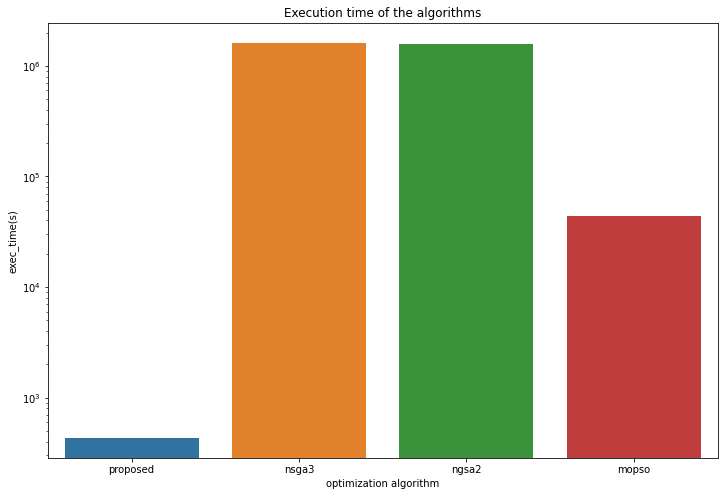

In [20]:
plt.figure(figsize=(12,8))
sns.barplot(data=all_data,x='optimization algorithm',y='exec_time(s)')
plt.yscale('log')
#sns.barplot(data=all_data,x='source',y='exec_time')
plt.title('Execution time of the algorithms')
plt.show()

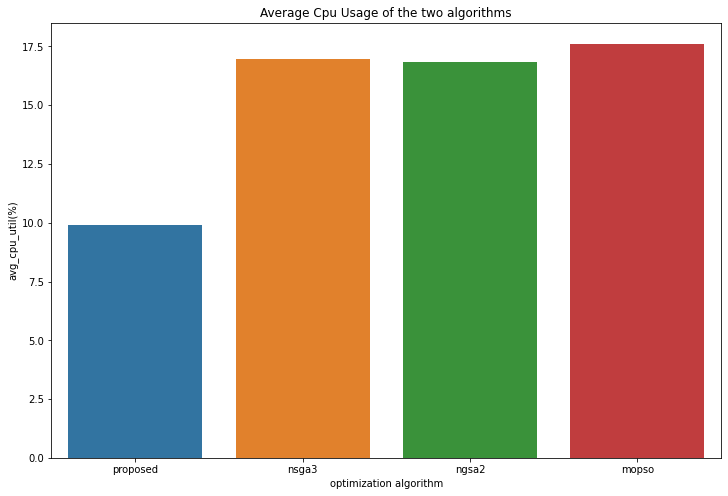

In [21]:
plt.figure(figsize=(12,8))
#sns.barplot(data=all_data,x='source',y='avg_cpu_util')
sns.barplot(data=all_data,x='optimization algorithm',y='avg_cpu_util(%)')
plt.title('Average Cpu Usage of the two algorithms')
plt.show()

In [22]:
#plt.figure(figsize=(12,8))
#sns.barplot(data=all_data,x='optimization algorithm',y='core_load(%)')
#plt.yscale('log')
#plt.title('Average core load of the algorithms')
#plt.show()

<Figure size 864x576 with 0 Axes>

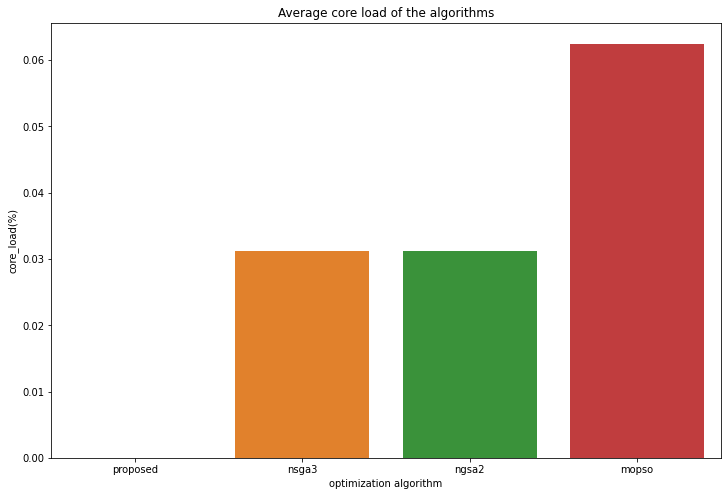

In [23]:
plt.figure(figsize=(12,8))
#sns.barplot(data=all_data,x='source',y='core_load')
#sns.barplot(data=all_data,x='optimization algorithm',y='total_cpu_usage')
#plt.yscale('log')
#plt.title('Average Cpu Usage of the two algorithms')
#plt.show()
plt.figure(figsize=(12,8))
sns.barplot(data=all_data,x='optimization algorithm',y='core_load(%)')
#plt.yscale('log')
plt.title('Average core load of the algorithms')
plt.show()

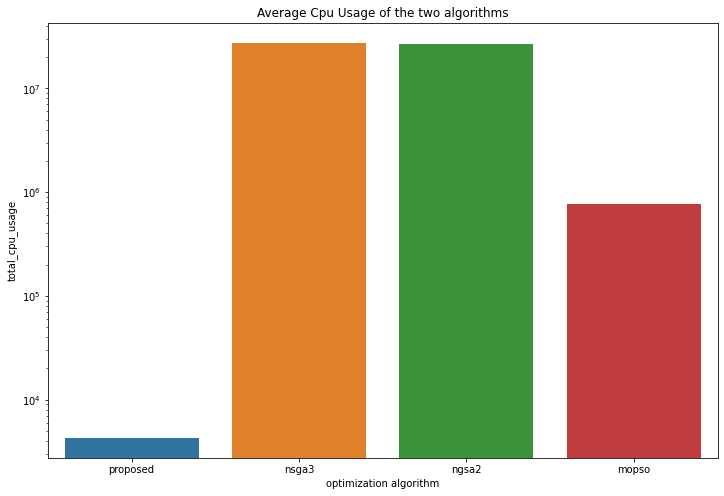

In [24]:
plt.figure(figsize=(12,8))
#sns.barplot(data=all_data,x='source',y='total_cpu_usage')
sns.barplot(data=all_data,x='optimization algorithm',y='total_cpu_usage')
plt.yscale('log')
plt.title('Average Cpu Usage of the two algorithms')
plt.show()

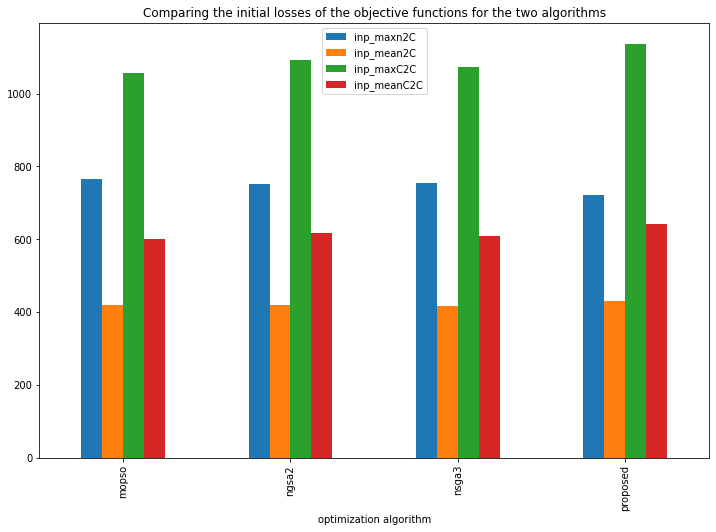

In [25]:
means.plot(y=inp_losses_cols,x='optimization algorithm',kind='bar',figsize=(12,8))
plt.title('Comparing the initial losses of the objective functions for the two algorithms')
plt.show()

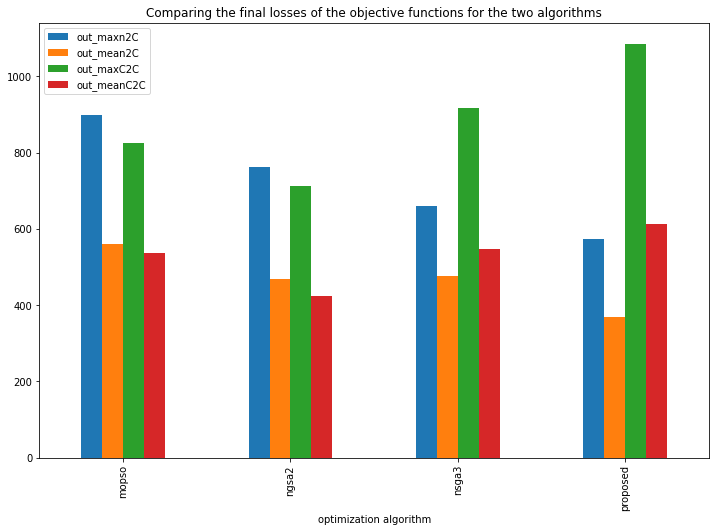

In [26]:
means.plot(y=out_losses_cols,x='optimization algorithm',kind='bar',figsize=(12,8))
plt.title('Comparing the final losses of the objective functions for the two algorithms')
plt.show()

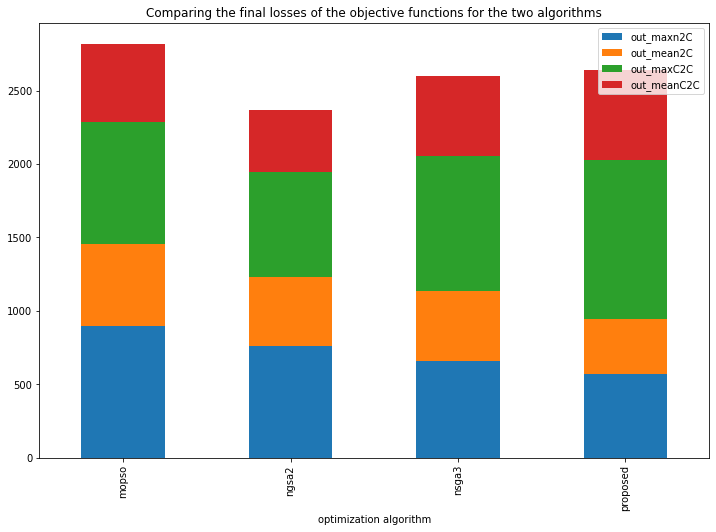

In [27]:
means.plot(y=out_losses_cols,x='optimization algorithm',kind='bar',stacked=True,figsize=(12,8))
plt.title('Comparing the final losses of the objective functions for the two algorithms')
plt.show()

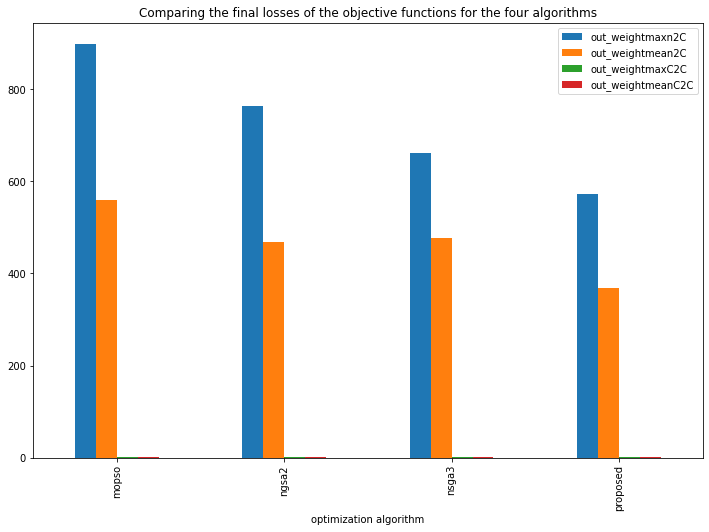

In [32]:
means.plot(y=out_new_losses_cols,x='optimization algorithm',kind='bar',stacked=False,figsize=(12,8))
plt.title('Comparing the final losses of the objective functions for the four algorithms')
plt.show()

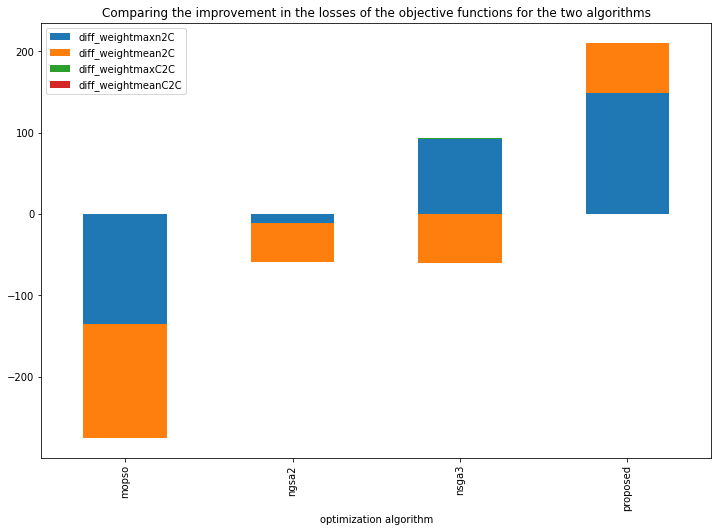

In [29]:
means.plot(y=new_diff_losses,x='optimization algorithm',kind='bar',stacked=True,figsize=(12,8))
plt.title('Comparing the improvement in the losses of the objective functions for the two algorithms')
plt.show()

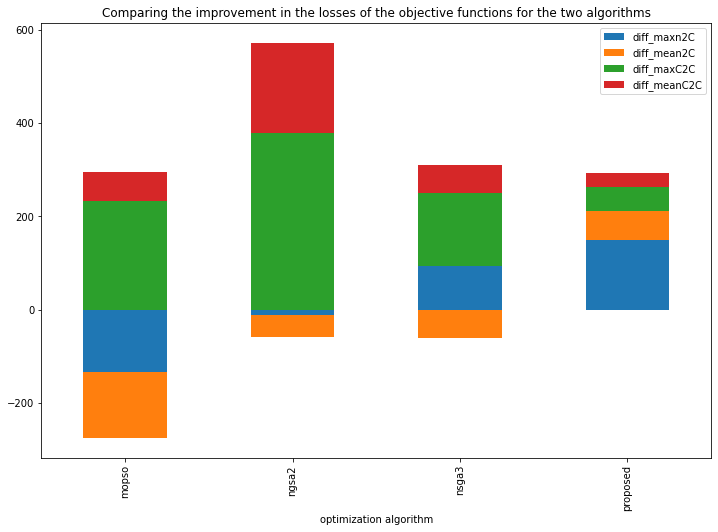

In [30]:
means.plot(y=diff_losses,x='optimization algorithm',kind='bar',stacked=True,figsize=(12,8))
plt.title('Comparing the improvement in the losses of the objective functions for the two algorithms')
plt.show()

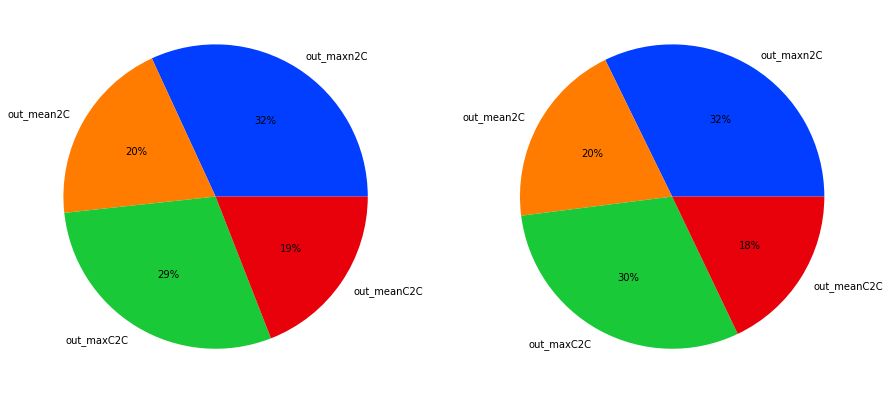

In [31]:
palette_color = sns.color_palette('bright')
fig, ax = plt.subplots(1, 2,figsize=(15, 7)) 
ax[0].pie(means.loc[0,out_losses_cols], labels=out_losses_cols, colors=palette_color, autopct='%.0f%%')
ax[1].pie(means.loc[1,out_losses_cols], labels=out_losses_cols, colors=palette_color, autopct='%.0f%%')
plt.show()